# LAPD lab - Machine learning project

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [ ]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sys
import itertools

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Seed definition

In an attempt for reproducibility, we define a torch seed for random processes.

In [ ]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [ ]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)
import sys
# Append the directory to your python path using sys
sys.path.append('drive/MyDrive/CSS 433/data')
# Import the module
print("importing helper_functions")
#import helper_functions_py
from helper_functions_py import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
labels.npy
ground_truth.npy
persistent_level.npy
meteo.xlsx
X.npy
iraddiance_raw.xlsx
meteo_time_raw.xlsx
__pycache__
.ipynb_checkpoints
helper_functions_py.py
meteo_summary.xlsx
median_Q1_Q3.xlsx
labels_only_meteo.xlsx
meteo_data_only.xlsx
importing helper_functions


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [ ]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, meteo, labels, mean_std, median_Q1_Q3, transform_label=0, normalise_meteo=False, label_outliers = False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            meteo     (string) : Name of the file with the meteo data
            labels    (string) : Name of the file with the labels (predictions)
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """

        self.root_dir = root_dir

        # Define the transforms to apply to labels or input
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo
        self.label_outliers = label_outliers

        # Read the excel content of the meteo_data and labels
        meteo_data = pd.read_excel(os.path.join(self.root_dir, meteo))
        labels_data = pd.read_excel(os.path.join(self.root_dir, labels))

        # Convert the individual columns to PyTorch tensors and normalise if required
        self.day        = torch.tensor(meteo_data['day'].values,        dtype=torch.float32)
        self.month      = torch.tensor(meteo_data['month'].values,      dtype=torch.float32)
        self.year       = torch.tensor(meteo_data['year'].values,       dtype=torch.float32)
        self.hour       = torch.tensor(meteo_data['hour'].values,       dtype=torch.float32)
        self.minute     = torch.tensor(meteo_data['minute'].values,     dtype=torch.float32)
        self.GHI        = torch.tensor(meteo_data['GHI'].values,        dtype=torch.float32)
        self.air_temp   = torch.tensor(meteo_data['air_temp'].values,   dtype=torch.float32)
        self.wind_speed = torch.tensor(meteo_data['wind_speed'].values, dtype=torch.float32)
        self.wind_dir   = torch.tensor(meteo_data['wind_dir'].values,   dtype=torch.float32)
        self.cosmonth   = torch.tensor(meteo_data['cosmonth'].values,   dtype=torch.float32)

        self.labels     = torch.tensor(labels_data['labels'].values,    dtype=torch.float32)

        # Load mean and std values from mean_std Excel file
        mean_std_df = pd.read_excel(os.path.join(self.root_dir, mean_std))
        self.mean_std_dict = dict(zip(mean_std_df['Column'], zip(mean_std_df['Mean'], mean_std_df['Std'])))

        self.meteo_columns = ['day', 'month', 'year', 'hour', 'minute', 'GHI', 'air_temp', 'wind_speed', 'wind_dir', 'cosmonth']

        # Read the excel content of the median, Q1 and Q3 values
        self.median_Q1_Q3_values = pd.read_excel(os.path.join(self.root_dir, median_Q1_Q3))
        # Check the loaded values
        print("Loaded median, Q1, Q3 values:")
        print(self.median_Q1_Q3_values.head())
        # Ensure the time-related columns are present
        if 'Hour' not in self.median_Q1_Q3_values.columns or 'Minute' not in self.median_Q1_Q3_values.columns:
            raise ValueError("Time-related columns (Hour, Minute) not found in median_Q1_Q3 Excel file.")
        else : print('Time related columns are here')


    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Convert idx to a list for consistency
        if not isinstance(idx, list):
            idx = [idx]


        # Import from memory only the data that we want
        labels     = self.labels[idx]
        cosmonth   = self.cosmonth[idx]
        GHI        = self.GHI[idx]
        day        = self.day[idx]
        month      = self.month[idx]
        year       = self.year[idx]
        hour       = self.hour[idx]
        minute     = self.minute[idx]
        air_temp   = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir   = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, cosmonth),dim=1)

        if self.label_outliers:
            # Combine hour and minute to create a time identifier
            print(hour, minute)
            time_identifier = (hour * 60) + minute
            time_identifier = time_identifier.numpy()


            # Get the corresponding median, Q1, and Q3 values for the specific time
            time_info = self.median_Q1_Q3_values[(abs(self.median_Q1_Q3_values['Hour'] * 60 + self.median_Q1_Q3_values['Minute'] - time_identifier) < 0.1)]
            if not time_info.empty:
                # Extract median, Q1, and Q3 values
                median_value = time_info['Median'].values[0]
                Q1_value = time_info['Q1'].values[0]
                Q3_value = time_info['Q3'].values[0]

                # Identify and adjust outliers in labels
                outliers_lower = labels < Q1_value
                outliers_upper = labels > Q3_value
                labels[outliers_lower] = median_value
                labels[outliers_upper] = median_value

                print(f"Adjusted outliers for time {time_identifier}: {len(labels[outliers_lower])} labels below Q1, {len(labels[outliers_upper])} labels above Q3")
            else : print(time_info, "Time info seems to be empty", time_identifier)

        # Apply the transforms

        if self.transform_label != 0:
            labels /= self.transform_label

        has_nan = torch.isnan(labels).any().item()
        if has_nan:
            print("The tensor contains NaN values.", meteo_data)

        if self.normalise_meteo:
            # Normalize meteo_data using mean and std values
            for i in range(meteo_data.shape[1]):
                column_name = self.meteo_columns[i]
                mean, std = self.mean_std_dict[column_name]
                meteo_data[:, i] = (meteo_data[:, i] - mean) / std

            #print('Meteo data has been normalised.', self.mean_std_dict)

        data = (meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [ ]:
ghi_dataset_normalised = GHIDataset(path,'meteo_data_only.xlsx','labels_only_meteo.xlsx', 'meteo_summary.xlsx', 'median_Q1_Q3.xlsx', normalise_meteo = True)

In [ ]:
ghi_dataset_normalised[0]

Meteo data has been normalised. {'day': (15.81031894683838, 8.694781303405762), 'month': (6.731246948242188, 3.806845664978027), 'year': (2021.990600585938, 0.3909047544002533), 'hour': (11.50731468200684, 6.922206401824951), 'minute': (25.00065040588379, 17.07826805114746), 'GHI': (169.0678863525391, 352.0543823242188), 'air_temp': (13.02392196655273, 8.751797676086426), 'wind_speed': (1.246735453605652, 0.7566677331924438), 'wind_dir': (204.8856811523438, 91.53279113769531), 'cosmonth': (0.155388280749321, 0.7351160645484924)}


(tensor([[-1.1283,  1.3840, -2.5341, -1.5179, -1.4639, -0.4734, -1.3510,  0.4669,
           1.2249,  1.1490]]),
 tensor([2.4000]))

In [ ]:
ghi_normalised_outliers = GHIDataset(path,'meteo_data_only.xlsx','labels_only_meteo.xlsx', 'meteo_summary.xlsx', 'median_Q1_Q3.xlsx', normalise_meteo = True, label_outliers = True)

Loaded median, Q1, Q3 values:
   Hour  Minute  Median   Q1   Q3
0     0       0     3.2  3.2  3.2
1     0      10     3.2  3.2  3.2
2     0      20     3.2  3.2  3.2
3     0      30     3.2  3.2  3.2
4     0      40     3.2  3.2  3.2
Time related columns are here


In [ ]:
ghi_normalised_outliers[0:3]

tensor([1., 1., 1.]) tensor([ 0., 10., 20.])


ValueError: ignored

In [ ]:
# Find indices for the following time stamps. These correspond to the etremeties of the validation sets when using the images
timestamps_to_search = [(27, 1, 2022, 12, 50), (10, 2, 2022, 12, 30), (7, 7, 2022, 15, 30), (19, 7, 2022, 20, 10), (18, 9, 2022, 11, 0), (25, 9, 2022, 13, 40)]  # Replace with your desired timestamps
indices = find_indices_by_timestamps(ghi_dataset, timestamps_to_search)
print(f"Indices of data with timestamps \n{timestamps_to_search} \n{indices}")


Indices of data with timestamps 
[(27, 1, 2022, 12, 50), (10, 2, 2022, 12, 30), (7, 7, 2022, 15, 30), (19, 7, 2022, 20, 10), (18, 9, 2022, 11, 0), (25, 9, 2022, 13, 40)] 
[7206, 9208, 20941, 22697, 31425, 32449]


In [ ]:
# The validation sets represent 10% of the dataset.
start_indices = [7206, 20941, 31425]
end_indices = [9206, 22697, 32449]
training_set, validation_sets = split_at_locations(ghi_dataset, start_indices, end_indices)
validation_set1, validation_set2, validation_set3 = validation_sets[0], validation_sets[2], validation_sets[2]

Let's get the mean and standard deviation of all meteo data in order to normalise them later on. We might also want to do it for the labels. In order to avoid data_leakage we will compute those values on the training set only.

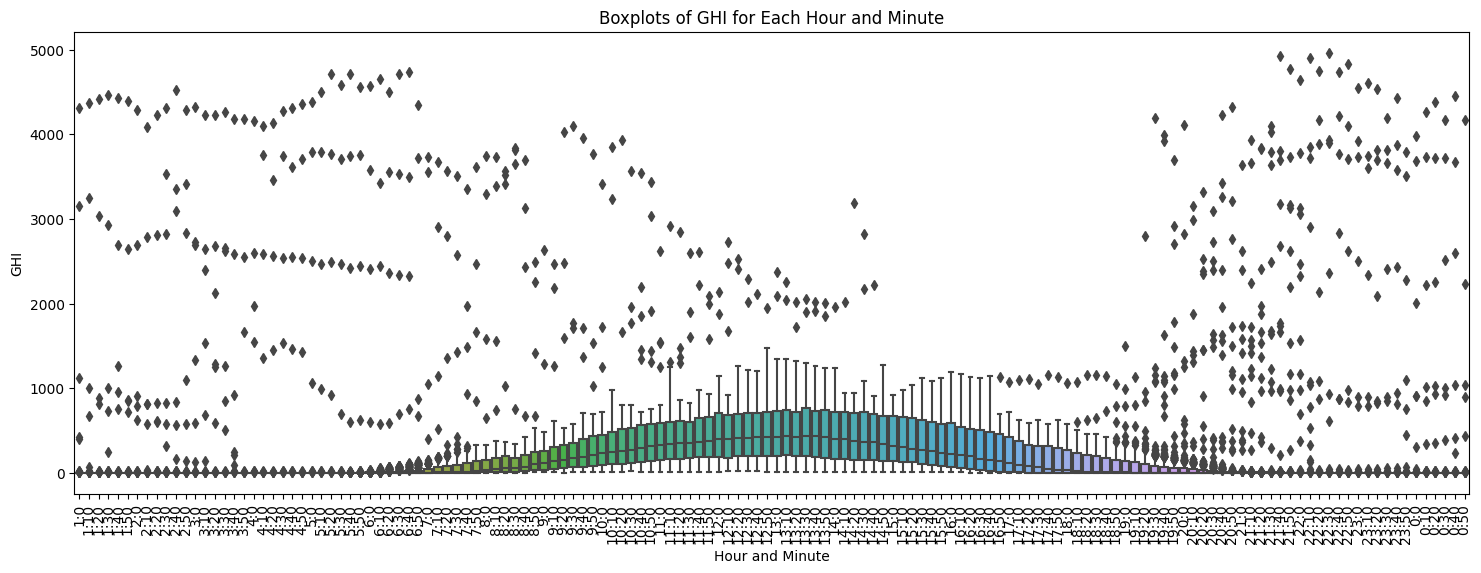

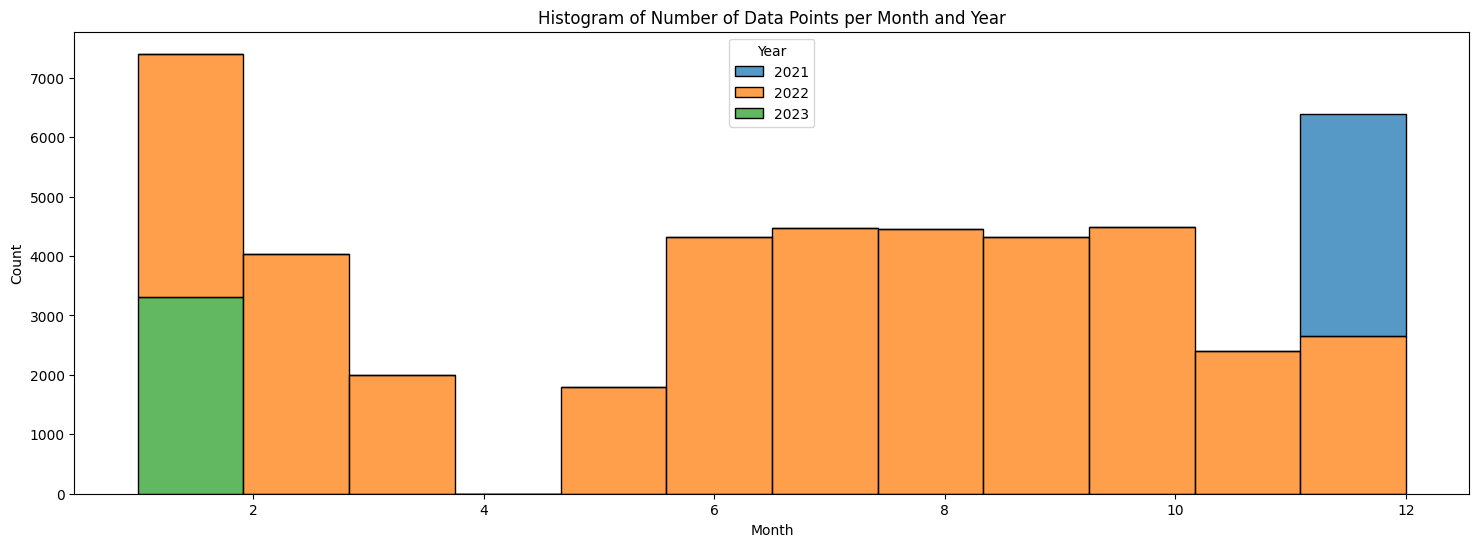

In [ ]:
plot_ghi_data_distribution(ghi_dataset)

In [ ]:
plot_ghi_data_distribution(ghi_normalised_outliers)

tensor([ 1.,  1.,  1.,  ..., 22., 22., 22.]) tensor([ 0., 10., 20.,  ..., 30., 40., 50.])


ValueError: ignored

Let's visualise the GHI values in boxplots according to the time they were recorded.

Let's make a summary excel sheet with the median, Q1 and Q2 of all the time stamps. This will allow us to adjust for outliers.

In [ ]:
def create_ghi_summary(ghi_dataset, output_path=None):
    """
    Create a summary DataFrame containing the hour, minute, median, Q1, and Q3 for each time.

    Parameters:
        df (pd.DataFrame): The DataFrame containing GHI data.
        output_path (str or None): The path to save the summary DataFrame as an Excel file. If None, the summary will be printed only.

    Returns:
        pd.DataFrame: The summary DataFrame.
    """
    ghi_dataset = ghi_dataset.dataset
    df = pd.DataFrame({
        'GHI': ghi_dataset.GHI.numpy(),
        'Hour': ghi_dataset.hour.numpy(),
        'Minute': ghi_dataset.minute.numpy(),
        'Month': ghi_dataset.month.numpy(),
        'Year': ghi_dataset.year.numpy()  # Assuming you have a 'year' attribute in your GHIDataset
    })

    # Convert Hour, Minute, Month, and Year columns to integers
    df['Hour'] = df['Hour'].astype(int)
    df['Minute'] = df['Minute'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)

    # Create a new column representing both hours and minutes as a string
    df['HourMinute'] = df['Hour'].astype(str) + ':' + df['Minute'].astype(str)

    # Group by hour and minute, and aggregate GHI data
    summary_df = df.groupby(['Hour', 'Minute']).agg({'GHI': ['median', 'quantile', 'quantile']}).reset_index()
    summary_df.columns = ['Hour', 'Minute', 'Median', 'Q1', 'Q3']

    # Print or use the summary DataFrame as needed
    print(summary_df)

    # Save the summary DataFrame to an Excel file if output_path is provided
    if output_path:
        summary_df.to_excel(output_path, index=False)

    return summary_df

In [ ]:
output_path = os.path.join(path, 'median_Q1_Q3.xlsx')
summary_df = create_ghi_summary(training_set,output_path)

     Hour  Minute  Median   Q1   Q3
0       0       0     3.2  3.2  3.2
1       0      10     3.2  3.2  3.2
2       0      20     3.2  3.2  3.2
3       0      30     3.2  3.2  3.2
4       0      40     3.2  3.2  3.2
..    ...     ...     ...  ...  ...
139    23      10     3.2  3.2  3.2
140    23      20     3.2  3.2  3.2
141    23      30     3.2  3.2  3.2
142    23      40     3.2  3.2  3.2
143    23      50     3.2  3.2  3.2

[144 rows x 5 columns]


<ipython-input-24-9dab6064d628>:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  summary_df = df.groupby(['Hour', 'Minute']).agg({'GHI': ['median', 'quantile', 'quantile']}).reset_index()


As can be seen on the graph above, there are many wrong values. Indeed the GHI values in Switzerland usually do not exceed 1000 (even 800 is high for this country). Furthermore, according to https://www.donneesmondiales.com/europe/suisse/coucher-soleil.php we can safely assume that values between 11PM and 5AM should be zero

### Data Separation

The data need to be split between train and test set.

Here we define a function to split the dataset into a test set, a validation set and a train set.

We also define a function to split the dataset in a given site to choose the test set we want.

Note that we do not shuffle the data as it is time dependent. What is significant here is that we test for the last values of the set.


#### Separation Functions
They are in the helper_functions.py now.

#### Choose our validation set

In [ ]:
#location = 12340

#ghi_train, ghi_test = split_at_location(ghi_dataset, location, 1000)

#print("Train set of size      : ", len(ghi_train))
#print("Validation set of size : ",len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))


Train set of size      :  45072
Validation set of size :  1000


## Definition of dataloaders

Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride (dec) between each batch to be customizable and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

#### Sequencer 1

In [ ]:
class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        print(self.data_source[i:i+self.batch_size].dtype)
        yield self.data_source[i:i+self.batch_size]
        i += self.dec

#### Sequencer 2

In [ ]:
class SequentialBatchSampler2:
    def __init__(self, data_source, batch_size, L,validation = False):
        self.data_source = data_source
        self.batch_size = batch_size
        self.L = L
        self.validation = validation

    def __iter__(self):
      i = 0
      indices = np.arange(len(self.data_source)-self.L)+self.L
      if not self.validation:
        np.random.shuffle(indices)
      batch = []
      for idx in indices:
        sample = self.data_source[idx-self.L:idx]
        batch.append(sample)
        if len(batch) == self.batch_size:
          yield batch
          batch = []


## Model

we defined and tested several models for our purpose.

- Only taking in account the images, convolutionnal layer + LSTM
- Taking in account the images and meteo data (not implemented yet)
- Transformer (not implemented yet)

This neural network will take in account meteo data.

### Network Definition

In [ ]:
class Net2(nn.Module):

    def __init__(self, out_channels=16, dropout = 0):
        super(Net2, self).__init__()
        #self.linear_layer = nn.Linear(5, 32*22*22)  # 5 is the number of additional features
        self.pre_fc1 = nn.Linear(9, 4*out_channels)  # Adjust input size and output size
        self.pre_fc2 = nn.Linear(4*out_channels, out_channels)   # Adjust output size
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.lstm1 = nn.LSTM(out_channels, 8*out_channels, batch_first=True)
        self.lstm2 = nn.LSTM(8*out_channels, 4*out_channels, batch_first=True)
        self.fc1 = nn.Linear(4*out_channels, 4*out_channels)
        self.fc2 = nn.Linear(4*out_channels, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x): #x1 and x2 correspond to the 2 images
        has_nan = torch.isnan(x).any().item()
        if has_nan:
            print("The tensor contains NaN values.")
            print(x)

        x = F.relu(self.pre_fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.pre_fc2(x))
        #x = self.dropout(x)
        #print(x.shape)
        #x = self.bn1(x)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        x = x.squeeze()

        return x

### Training / Validation Functions

In [ ]:
def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

def reset_weights(m,verbose=False):
  '''
    Method to reset the model weights between each fold or utilization
    Avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    if verbose:
      print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
  """
    method to train the model on a given training set
    return the loss at each step
  """
  # Set model to training mode (affects dropout, batch norm e.g.)
  model.train()
  loss_history = []
  lr_history = []
  # loop to get batch_idx, data and target from train_loader
  for batch_idx, data in enumerate(train_loader):
      # Move the data to the device
      data = list(feature.to(device) for feature in data)

      # The last element of the list data is the target so we remove it for the model
      target = data.pop()
      # Zero the gradients
      optimizer.zero_grad()

      # Compute model output
      # The input data is all the elements of the list data except the last
      output = model(*data)
      # Compute loss
      loss = criterion(output, target[...,-1])

      # Backpropagate loss
      loss.backward()
      # Perform an optimizer step
      optimizer.step()
      if scheduler != 0:
        scheduler.step()
      # Compute loss (float value, not a tensor)
      loss_float = loss.item()
      loss_history.append(loss_float)

  print(
    f"Train Epoch : {epoch}"
    f"train_loss = {np.sqrt(np.mean(loss_history))} "
  )

  return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
  """
    method to validate the model on a given validation set
    return the loss at each step
  """
  model.eval()  # Important: eval mode (affects dropout, batch norm etc)
  test_loss = 0
  history = []

  for data in val_loader:
    data = list(feature.to(device) for feature in data)
    target = data.pop()
    output = model(*data)

    test_loss = criterion(output, target[...,-1]).item()
    history.append(test_loss)

  print(
    "Test set: Average loss: {:.4f}".format(
       np.sqrt(np.mean(history)),
       len(val_loader.dataset)
      )
  )
  return history

## Cross-validation
Hyper-paremeters to tune:
- Kernel sizes : size of the different filters (keep odd number https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1)
- Dropout rates: there are two dropout rates to hyperparameter
- Batch-size
- Activation function maybe (Softmax, ReLu, Softplus, Leaky ReLu, PReLu)
- number of epoch
- img_size
- optimizer parameters (lr, weight_decay)

### Code

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Constant

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
) # constant

# Variables
batch_size = [8]
L = [3]
dropout = [0, 0.1, 0.2, 0.3]
num_epochs = 30

# Combine hyperparameters
hyperparameter_combinations = list(itertools.product(L, batch_size, dropout))

# Define the K-fold Cross Validation
folds = 4
kfold = KFold(n_splits=folds, shuffle=False)
#criterion = RMSELoss
criterion = RMSELoss #criterion for the training


# initialize each variables
result_model = []
result_best_val_loss = []  # Initialize with positive infinity
result_best_epoch = []



#iterate on each fold
for L_, batch_size_, dropout_ in hyperparameter_combinations :
  model = Net2(dropout = dropout_)
  model = model.to(device=device)
  print('L: ', L_, 'batch size: ', batch_size_, 'dropout: ', dropout_)

  for fold, (train_ids, test_ids) in enumerate(kfold.split(ghi_dataset)):


      print("fold ", fold+1) # just by convenience, first fold, second fold....

      # prepare the train and validation set and corresponding loaders
      train_subset = Subset(ghi_dataset, train_ids)
      validation_subset = Subset(ghi_dataset, test_ids)
      #define the loader
      train_loader = DataLoader(train_subset, batch_sampler=SequentialBatchSampler2(np.arange(len(train_subset)), batch_size=batch_size_, L=L_))
      val_loader = DataLoader(validation_subset, batch_sampler=SequentialBatchSampler2(np.arange(len(validation_subset)), batch_size=batch_size_, L=L_))

      #prepare the model
      model.apply(reset_weights)
      optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // batch_size_,)
      # ===== Train Model =====
      best_val_loss = float('inf')  # Initialize with positive infinity
      best_epoch = 0
      #train_loss_history = []
      train_loss_step = []
      #val_loss_history = []
      val_loss_step = []
      for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
      #train_loss_history.extend(train_loss)
        train_loss_step.append(np.sqrt(np.mean(train_loss)))

        val_loss = validate(model, device, val_loader, criterion)
      #val_loss_history.extend(val_loss)
        loss = np.sqrt(np.mean(val_loss))
        val_loss_step.append(loss)

      # Save the model with the lowest validation loss
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          best_model_state = model.state_dict()

      print("best loss",best_val_loss, "epoch", best_epoch)
      result_model.append(best_model_state)
      result_best_val_loss.append(best_val_loss)
      result_best_epoch.append(best_epoch)

      # ===== Plot training curves =====
      t_val = np.arange(1, num_epochs + 1)

    # Increase the size of the plot
      plt.figure(figsize=(20, 16))

      plt.subplot(2, 3, 2)
      plt.plot(t_val, train_loss_step, label="Train")
      plt.plot(t_val, val_loss_step, label="Val")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.show()

  # define best parameters
  mean_loss = np.mean(result_best_val_loss)
  mean_epoch = math.ceil(np.mean(result_best_epoch))
  print("best loss",np.mean(result_best_val_loss), "epoch", mean_epoch)


L:  3 batch size:  8 dropout:  0
fold  1
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3, 16])
torch.Size([8, 3

KeyboardInterrupt: ignored

## Final model


### Training

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net2(dropout = 0.1)
model = model.to(device=device)
model.apply(reset_weights)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)


criterion = F.mse_loss #criterion for the training

#parameter
#num_epochs = mean_epoch
num_epochs = 25
batch_size = 8


#define the loader
#ghi_train_shuffle = shuffle(ghi_train)
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=8, dec = 8))
train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_train)),L=2,batch_size=batch_size))
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#        optimizer,
#       T_max=(len(train_loader.dataset) * num_epochs) // batch_size,)
scheduler = 0

# ===== Train Model =====
train_loss_history = []
train_loss_step = []
for epoch in range(1, num_epochs + 1):
  print("Epoch : ",epoch,"/",num_epochs)
  train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.sqrt(np.mean(train_loss)))

# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Epoch :  1 / 25
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 16])
torch.Size([8, 2, 

KeyboardInterrupt: ignored


### Validation

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/CSS 433/data/model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

In [ ]:
torch.cuda.empty_cache()

the test loss is  61.08521275172443


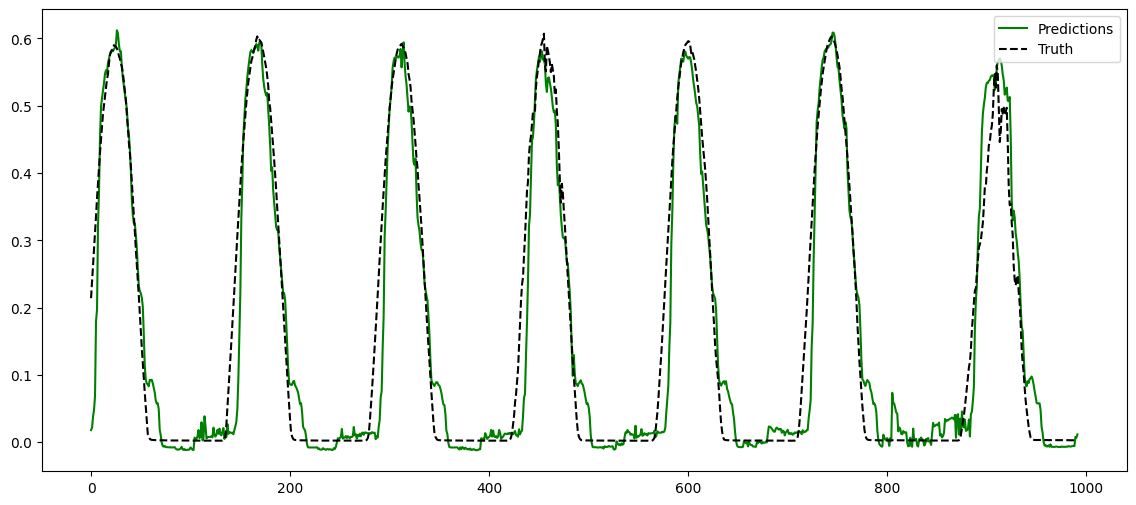

In [ ]:

test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test)),L=2,batch_size=8,validation=True))

criterion = F.mse_loss #criterion for the training
pred = []
truth = []
test_loss = []

model.eval()
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = 1000*data.pop()
  output = 1000*model(*data)

  pred.extend(output.tolist())
  truth.extend(target[...,-1].tolist())
  test_loss.append(criterion(output, target[...,-1]).item())

Loss = np.sqrt(np.mean(test_loss))

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')

<ipython-input-32-b0496dcf6a13>:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss.append(criterion(output,target[...,-1]).item())


the test loss is  60.9032291172359


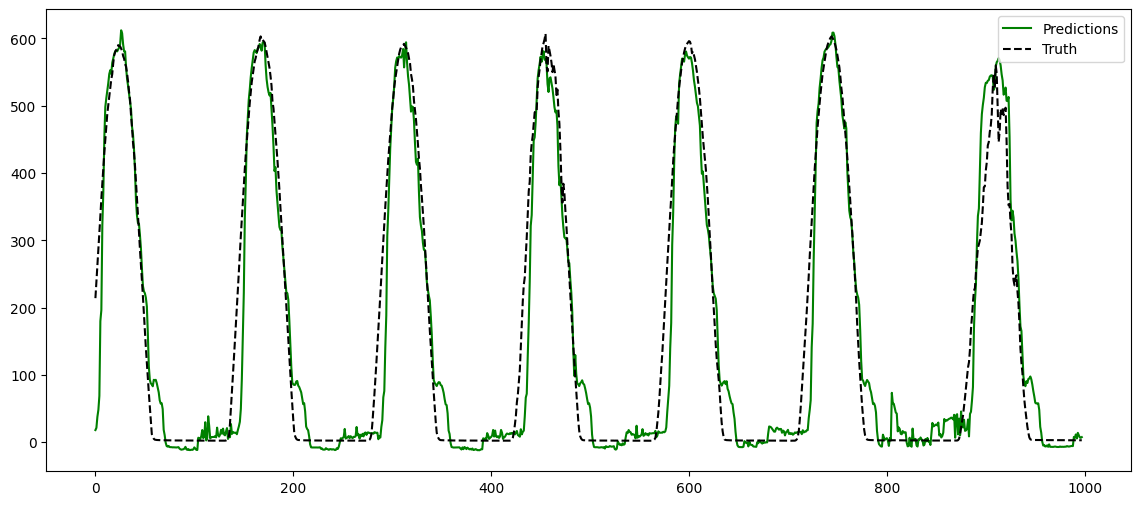

In [ ]:
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test)),L=2,batch_size=1,validation=True))


criterion = F.mse_loss #criterion for the training
pred = []
truth = []
test_loss = []
model.eval()
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = 1000*data.pop()
  output = 1000*model(*data)
  pred.append(output.item())
  truth.append(target[...,-1].item())
  test_loss.append(criterion(output,target[...,-1]).item())

Loss = np.sqrt(np.mean(test_loss))

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')

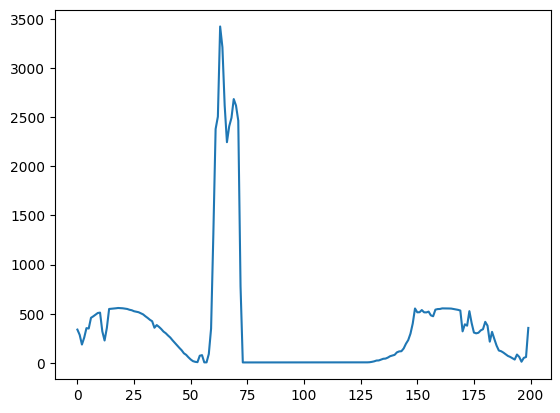

In [ ]:
a = 34000
b = 200
plt.plot(ghi_dataset[a:a+b][-1])